In [1]:
import numpy as np
import lightcones as lc
import lightcones.linalg as la
import matplotlib.pyplot as plt
from lightcones.linalg import mv
from lightcones import models
from lightcones.jumps import make_jump
from lightcones.solvers.schrodinger import solve

In [2]:
# chain
n_sites = 100
# on-site energies
es = [1]*n_sites
# hoppings
hs = [0.05]*(n_sites-1)

# time grid
dt = 0.01
nt = 80000

# spread
spread = lc.spread(es, hs, nt, dt)

# rho_plus
rho_plus = lc.rho_plus(spread, dt)

# minimal light cone
rtol = 10**(-4)
ti_arrival, spread_min, U_min, rho_plus_min = lc.minimal_forward_frame(spread, rho_plus, dt, rtol)

# causal diamond frame
cd_dim = 4
spread_cd, U_cd = lc.causal_diamond_frame(spread_min, ti_arrival, U_min, rho_plus_min, dt, rtol, cd_dim)

# moving frame
spread_mv, H_mv = lc.moving_frame(spread_cd, ti_arrival, U_cd, dt, cd_dim)

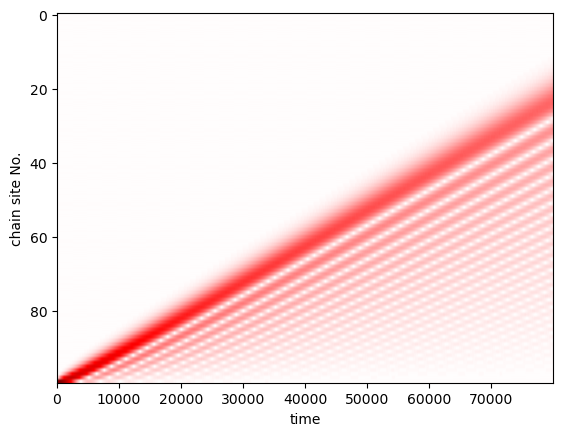

In [3]:
max_ = np.max(np.abs(spread))
im = plt.imshow(np.flip(np.abs(spread), axis=0), aspect='auto', cmap = 'seismic', vmin = - max_, vmax = max_)
plt.xlabel('time')
plt.ylabel('chain site No.')
plt.savefig('coupling_site_spread.eps', format = 'eps')

In [4]:
import numpy as np
from numpy import linalg as LA
import random
from lightcones.jumps import density_matrix

def make_number_jump(psi, space, mode_index, reset_to_vac = True, jump_index = None):

    if jump_index is None:
        # find the jump probabilities
        rho = density_matrix(psi, space, mode_index)
        jump_probs = np.diag(rho)
    
        # select the jump 
        xi = random.random()
        jump_index = 0
        local_dim = len(jump_probs)
        for k in range(0, local_dim):
            xi = xi - jump_probs[k]
            if xi < 0:
                jump_index = k
                break
    
    psi_collapsed = np.zeros(space.dimension, dtype = complex)
    # apply the jump
    if reset_to_vac:
        psi_collapsed = psi_collapsed + space.outer(0, jump_index, mode_index) @ psi
    else:
        psi_collapsed = psi_collapsed + space.outer(jump_index, jump_index, mode_index) @ psi
        
    # normalize    
    psi_collapsed = psi_collapsed / np.sqrt(np.vdot(psi_collapsed, psi_collapsed))
    
    return psi_collapsed, jump_index

In [10]:
def generate_history(max_num_quanta, jump_indices = None):
    # Compute history a

    # Time step
    dt = 0.01

    # Final grid
    t_max = 200
    t = np.arange(0, t_max + dt, dt)
    n_time = t.size

    num_modes = lc.m_in(ti_arrival, n_time - 1)
    m = models.spin_boson(num_modes, max_num_quanta)

    wq = 1.0
    Hs = wq * m.s_p @ m.s_m
    g = 0.002
    V = g * m.s_m
    V_dag = g * m.s_p

    def f(ti):
        return(0.1*np.cos((ti + 0.5)*dt))

    psi_0 = np.zeros(m.dimension, dtype = complex)
    psi_0[0] = 1

    Ht = None
    Hint = m.space.zero_op

    m_out_prev = 0

    psi_history = []
    jump_history = []

    def begin_step(ti, psi):
        m_out, m_in = lc.get_inout_range(ti_arrival, ti, cd_dim)
        
        # if the number of decoupled modes is changed: we need to make a jump
        nonlocal m_out_prev
        if m_out != m_out_prev:
            if jump_indices is not None:
                jump_index = jump_indices[m_out_prev]
            else:
                jump_index = None
            psi[:], jump_index = make_number_jump(psi, m.space, m_out_prev + 1, reset_to_vac = False, jump_index = jump_index) # + 1 because the first mode is the qubit
            jump_history.append(jump_index)
            m_out_prev = m_out 
        
        nonlocal Hint
        if m_in > 0:
            Hint = V_dag @ sum(spread_mv[: num_modes, ti] * m.a[:])
            Hint = Hint + Hint.conj().transpose()
        nonlocal Ht
        Ht = Hs + m.s_x * f(ti) + Hint
        Hw = m.zero_op
        W = lc.get_H(ti_arrival, H_mv, ti)
        if not W is None:
            for p in range(m_in - m_out):
                for q in range(m_in - m_out):
                    Hw += 1j * m.a_dag[m_out + q] @ m.a[m_out + p] * W[q, p].conj()
        Ht = Ht + Hw
    
    def apply_h(ti, psi_in, psi_out):
        mv(Ht, psi_in, psi_out)

    # Here we store the average of observables
    s_z_av = []

    def eval_o(ti, psi):
        s_z_av.append(np.vdot(psi, m.s_z @ psi))
        psi_history.append(psi.copy())

    solve(0, n_time-1, dt, apply_h, psi_0, begin_step = begin_step, eval_o = eval_o)

    return psi_history, jump_history, t, np.array(s_z_av).real

In [7]:
for ti in lc.get_outgoing_times(ti_arrival, cd_dim):
    print(dt * ti)

55.93
81.53
108.31
135.95
164.18
192.84
221.83
251.06
280.49
310.07
339.76
369.54
399.40000000000003
429.3
459.23
489.18
519.13
549.0600000000001
578.95
608.76
638.47
668.01
697.29
726.16
754.27
780.6700000000001
800.0


In [8]:
history = [2, 1, 1, 0, 1, 0]

In [11]:
_, _, t, s_z_4 = generate_history(4, history)

In [12]:
_, _, t, s_z_5 = generate_history(5, history)

In [16]:
_, _, t, s_z_6 = generate_history(6, history)

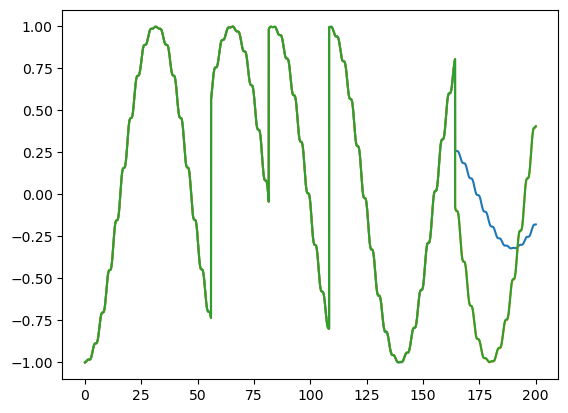

In [17]:
plt.plot(t, s_z_4)
plt.plot(t, s_z_5)
plt.plot(t, s_z_6)

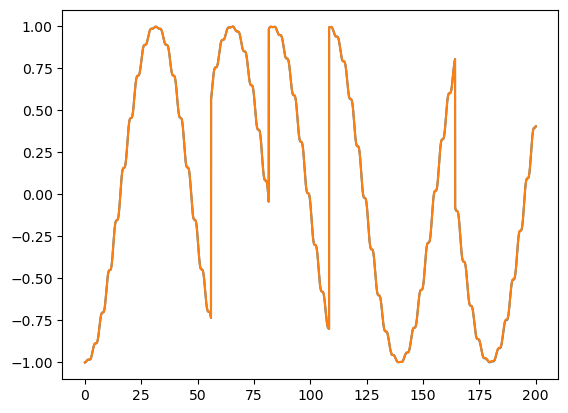

In [18]:
plt.plot(t, s_z_5)
plt.plot(t, s_z_6)